Stochastic Volatilty Models

#### Home work 1

---

The file must be sent to **stoch-vol-24-fall@yandex.ru** with topic "stoch-vol HW1". 

WARNING: topic is important! Inbox will be filtered automatcally based on exact match. 

Please zip all files into one folder and rename it as "SurnameName_HW1" before sending.

Deadline: 7th of October, 23:59.

If you have any questions feel free to ask in Telegram @v_antipov or @igortao.

Full name: ***Lyappieva Anastasiia***

Faculty: ***Mech-Math***

---

### Problem 1 (30 points)

**1**. 💅 <span style="color:blue">(10 points)</span>  Calculate and plot **put** option prices in Black-Scholes model as functions of the underlying asset price for different **exercise times** and different **volatilities**. Use parameters 

$$K = 1, \quad r = 0, \quad S \in [0.5, 1.5],$$

and $T \in \{0,\ \frac{1}{4},\ \frac{1}{2},\ \frac{3}{4},\ 1\}$ (time is measured in years) and $\sigma \in \{0.1, \ 0.2, \ 0.3\}$.

*Note: the answer should contain three plots (for each volatility $\sigma$), each of which shows option prices for different excercise times $T$.*

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
C:\Users\lyapp\AppData\Local\Temp\ipykernel_17008\1294702400.py:19: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f"$ \sigma $ = {vol}")


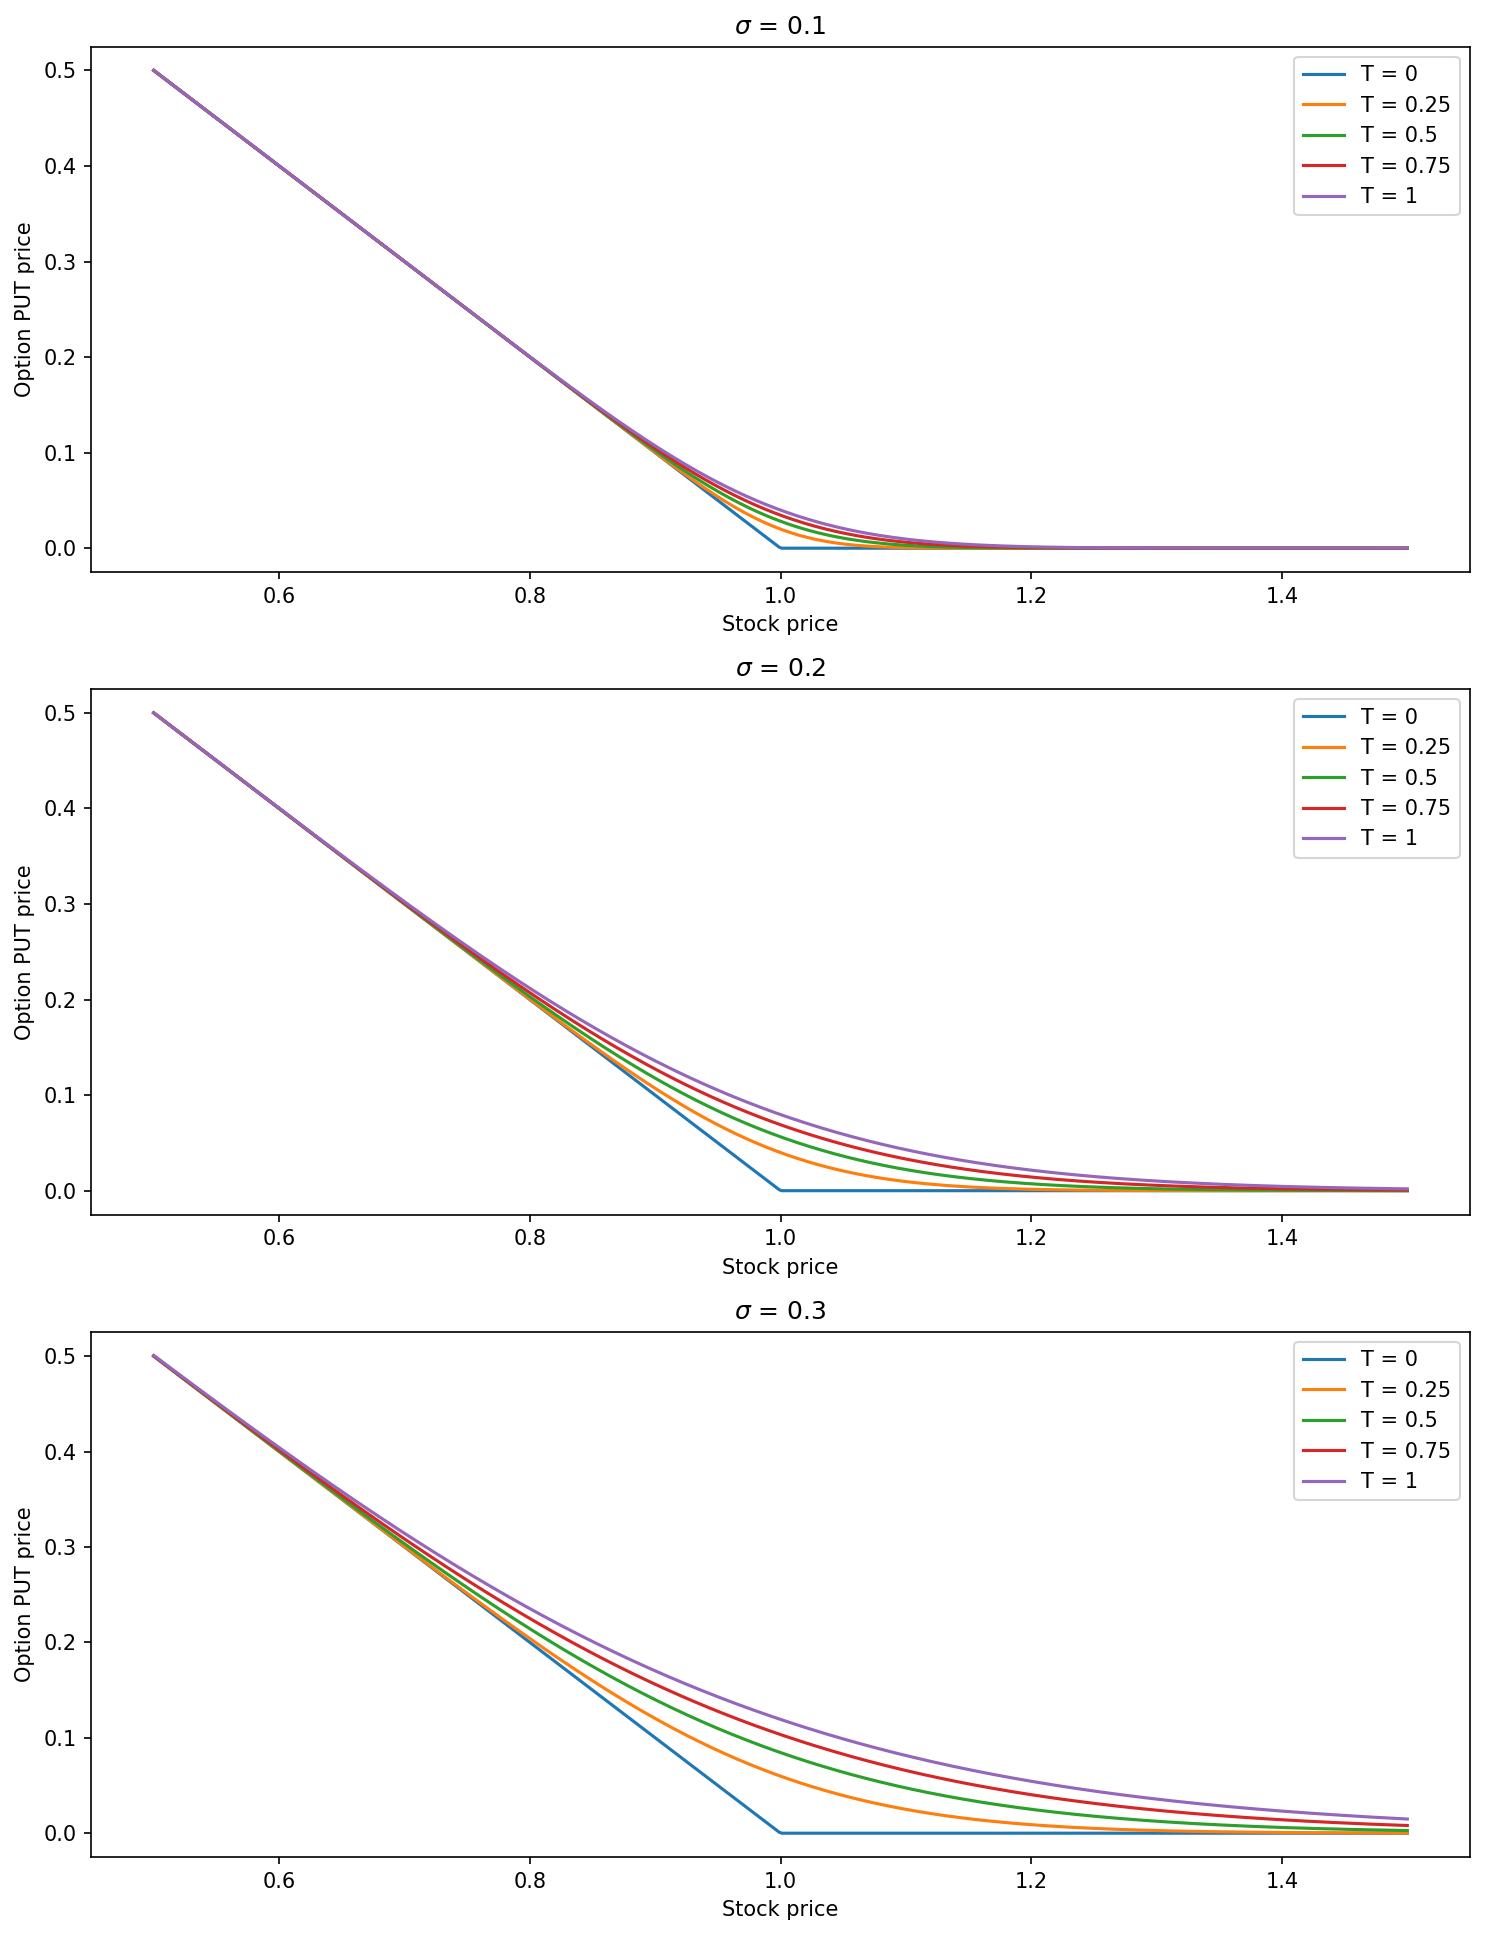

In [38]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

K = 1
r = 0
vols = [0.1, 0.2, 0.3]
maturities = [0, 1/4, 1/2, 3/4, 1]
S = np.linspace(0.5, 1.5, 500)
fig, axs = plt.subplots(nrows=3, figsize=(10, 13), dpi=150)
for vol, ax in zip(vols, axs):
    for T in maturities:
        if T == 0:
            V_put = np.maximum(K - S, 0) 
        else:
            d1 = 1/(vol*np.sqrt(T))*(np.log(S/K) + T*(r + vol**2/2))
            V_put = np.exp(-r*T)*K*norm.cdf(-d1 + vol*np.sqrt(T)) - S * norm.cdf(-d1)
        ax.plot(S, V_put, label = f"T = {T}")
    ax.set_title(f"$ \sigma $ = {vol}")
    ax.set_ylabel("Option PUT price")
    ax.set_xlabel("Stock price")
    ax.legend()
plt.tight_layout() #Команда plt.tight_layout() используется для автоматической корректировки размещения подграфиков на графике
plt.show()


**2**. 💅 <span style="color:blue">(5 points)</span>  What kind of dependence on the parameters of put option price do you observe? How does the price of a put option change with changes in volatility, time to expiration? Why? Provide the intuition. 

Чем меньше волатильность, тем сильнее графики прижимаются к PayOff PUT опциона. Это происходит потому что волатильность - это мера изменения цены и чем она больше, тем сильнее колебания. Значит, больше вероятность выиграть (и програть), как следствие цена за такой дериватив должна быть больше.

Чем больше время до экпирации, тем больше расстояние от графика цены до PayOff PUT опциона. То есть чем больше время, тем дороже опцион. Это означает, что если у опциона больше времени до истечения срока, то он с большей вероятностью получит большую прибыль.

**3**. 💅 <span style="color:blue">(15 points)</span> Replicate considered put option using the portfolio rebalanced $n$ times (i.e. every $dt = T/n$ units of time). Using simulations, estimate the distribution of the replication error.


    1) Generate m random trajectories of price process trajectories on the segment [0,t] with a step dt = T/n.

    2) For each trajectory at each moment of time, find a replicating portfolio. Assume that the initial value of the portfolio is equal to the option price.

    3) For each trajectory, calculate the difference between the value of the replicating portfolio at time T and the payout to be made on the option.

    4) Display the distribution of the obtained differences in the form of a histogram.


*Note: use $m = 2^{10} - 1$ and $n$ = 123*. 

---

Далее не обошлось без применения кода с семинаров.

**Пункт 1**

In [39]:
from typing import Union, Optional, Callable
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
from scipy import stats  
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

from ipywidgets import interact
from ipywidgets import widgets
from tqdm.auto import tqdm

In [40]:
FloatArray = npt.NDArray[np.float64]
Floats = Union[float, FloatArray] # указаваем в квадратных скобках возможные типы

In [41]:
@dataclass
class MarketState: # состояние рынка
    stock_price: Floats # в dataclass обязательно нужно указать после двоеточия какого типа у нас переменная
    interest_rate: Floats
    time: Floats = 0

@dataclass
class StockOption: # параметры опциона
    strike_price: Floats
    expiration_time: Floats  # in years # абсолютное время экспирации
    is_call: Union[bool, npt.NDArray[np.bool_]]
    
    def payoff(self, stock_price: Floats) -> Floats: # функция считает выплату опциона
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff) # смотрим если call, то выдаем call_payoff, иначе put_payoff
    
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)    

@dataclass 
class BSParams: # параметры модели Б-Ш
    volatility: Floats

In [42]:
def dt(option: StockOption, ms: MarketState): # dt - это разность между текущим временем и временем ло экпирации
    return np.maximum(option.expiration_time - ms.time, np.finfo(np.float64).eps)


def d1(option: StockOption, ms: MarketState, params: BSParams):
    return 1 / (params.volatility * np.sqrt(dt(option, ms)))\
                * (np.log(ms.stock_price / option.strike_price)
                   + (ms.interest_rate + params.volatility ** 2 / 2) * dt(option, ms))


def d2(option: StockOption, ms: MarketState, params: BSParams):
    return d1(option, ms, params) - params.volatility * np.sqrt(dt(option, ms))

In [43]:
def price(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))
    
    call_price = stats.norm.cdf(d1(option, ms, params)) * ms.stock_price\
            - stats.norm.cdf(d2(option, ms, params)) * option.strike_price * discount_factor
    put_price = stats.norm.cdf(-d2(option, ms, params)) * option.strike_price * discount_factor\
        - stats.norm.cdf(-d1(option, ms, params)) * ms.stock_price
    
    return np.where(option.is_call, call_price, put_price)

In [44]:
def delta(option: StockOption, ms: MarketState, params: BSParams):
    nd1 = stats.norm.cdf(d1(option, ms, params))
    return np.where(option.is_call, nd1, nd1 - 1)


In [45]:
def make_bsm_market_simulator(
    ms: MarketState,
    params: BSParams,
    time_stop: float,
    n_steps: int = 123,
):
    
    def simulate(n_paths: int, seed: int = 0xB0BA_C_3AB0DA):
        dt = (time_stop - ms.time) / n_steps
        random = np.random.default_rng(seed)
        norm = random.normal(size=(n_paths, n_steps)) # генерируем случайную величину, которая распределена стандартно нормально
        d_log_s = (
            (ms.interest_rate - params.volatility ** 2 / 2) * dt
            + params.volatility * norm * np.sqrt(dt)
        )
        d_log_s = np.insert(d_log_s, 0, np.zeros(n_paths), axis=1) # вставляем ноль в начало каждой строки
        return ms.stock_price * np.exp(np.cumsum(d_log_s, axis=-1))
    
    return simulate

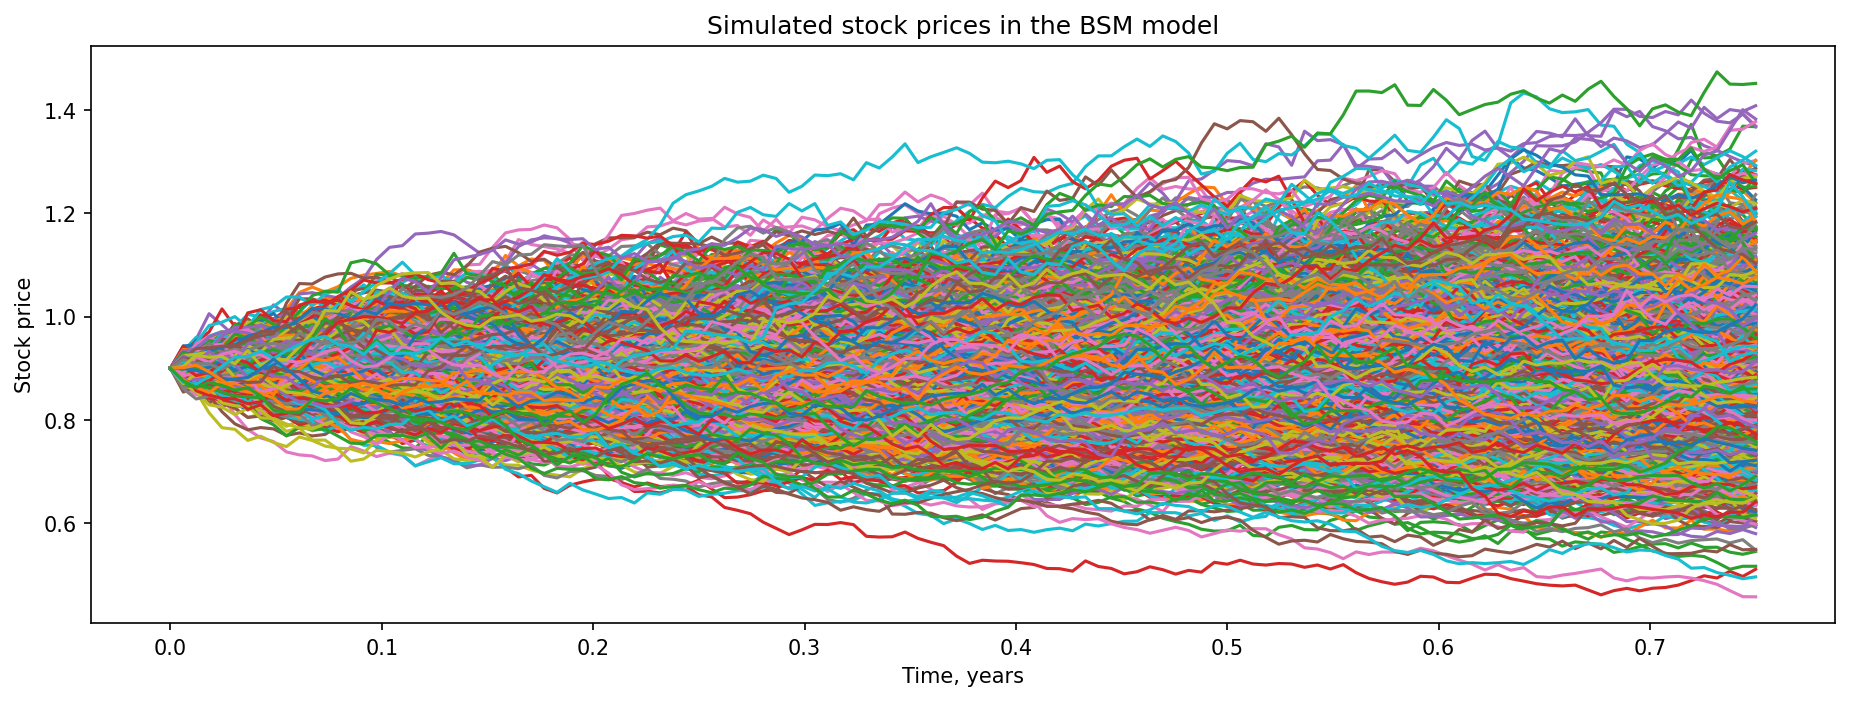

In [47]:
N = 1023
STEPS = 123
T = 3/4

ms = MarketState(stock_price=0.9, interest_rate=0)
params = BSParams(volatility=0.2)
sim_fn = make_bsm_market_simulator(ms, params, T, STEPS)
paths = sim_fn(N)
t = np.linspace(0, T, STEPS + 1)

_, ax = plt.subplots(figsize=(15, 5), dpi=150)
ax.plot(t, paths.T)
ax.set_xlabel("Time, years")
ax.set_ylabel("Stock price")
ax.set_title("Simulated stock prices in the BSM model")
plt.show()

**Пункт 2 - 4**

In [19]:
def calc_hedging_pnl(
    option: StockOption,
    ms: MarketState,
    params: BSParams,
    n_steps: int = 123,
    n_paths: int = 1023,
    seed: int = 0xB0BA_C_3AB0DA,
):
    sim_fn = make_bsm_market_simulator(ms, params, option.expiration_time, n_steps)
    paths = sim_fn(n_paths, seed)                                            # paths.shape == (n_paths, n_steps + 1)
    times = np.linspace(ms.time, option.expiration_time, n_steps + 1)[None]  # times.shape == (1,       n_steps + 1)
    bank_acc = 1.0 * np.exp(ms.interest_rate * (times - times[:, 0]))
    df = 1.0 / bank_acc #discount factor
    
    inter_ms = MarketState(
        stock_price=paths,
        interest_rate=ms.interest_rate,
        time=times,
    )
        
    opt_p = price(option, inter_ms, params)
    stock_pos = delta(option, inter_ms, params) # нуждо держать в каждый момент времени дельта акций
    bank_acc_pos = df * (opt_p - stock_pos * paths)
    hedging_pnl = (
        stock_pos[:, :-1] * np.diff(paths, axis=-1) #-1 - lines
        + bank_acc_pos[:, :-1] * np.diff(bank_acc, axis=-1)
    )
    payoff = -option.payoff(paths[:, [-1]])
    return np.append(hedging_pnl, payoff, axis=-1)

In [20]:
option = PutStockOption(strike_price=1.0, expiration_time=3/4)
ms = MarketState(stock_price=0.9, interest_rate=0.0)
params = BSParams(volatility=0.2)

In [27]:
p = price(option, ms, params)
p

array(0.12728826)

In [26]:
pl = -calc_hedging_pnl(
    option,
    ms,
    params,
    n_paths=1023,
    n_steps=123,
    seed=1,
).sum(-1)
pl.mean()

np.float64(0.12711661881768396)

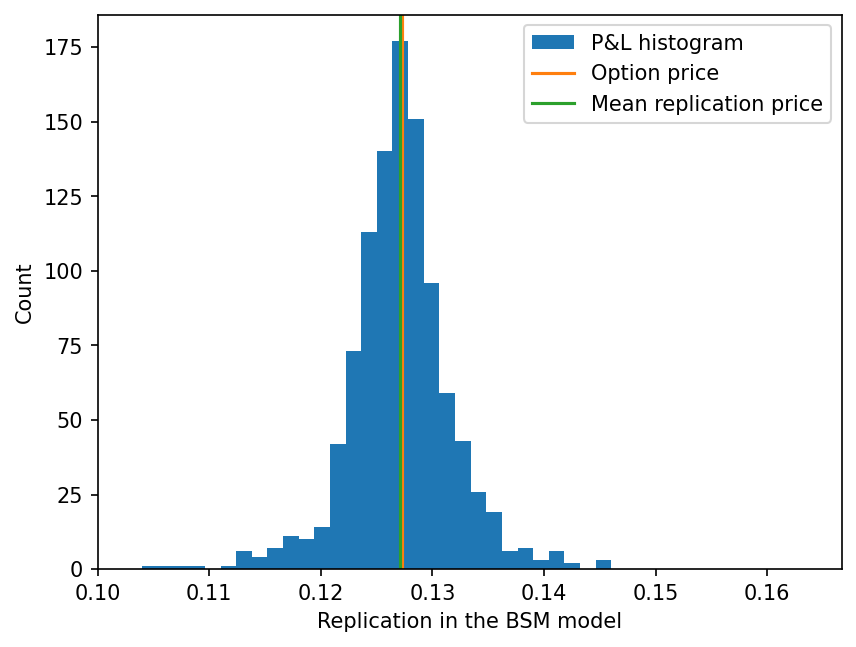

In [48]:
_, ax = plt.subplots(dpi=150)
ax.hist(pl, bins=30, label="P&L histogram")
ax.axvline(p, c="C1", label="Option price")
ax.axvline(pl.mean(), c="C2", label="Mean replication price")
ax.set_xlabel("Replication in the BSM model")
ax.set_ylabel("Count")
ax.set_xlim(1/10, 1/6)
ax.legend()
plt.show()

### Problem 2 (50 points)

Consider a simplified Stein-Stein stochastic volatility model, given by processes $(B_t, S_t, V_t)$ on $(\Omega, \mathcal F, (\mathcal F)_{t \geq 0}, \mathbb{P})$, with $\mathbb{P}$ being a **real-world** probability measure,

$$dB_t = rB_t dt, \quad B_0 = b,$$
$$dS_t = \mu S_t dt + V_t S_t dW^{1}_t, \quad S_0 = s,$$
$$dV_t = \kappa(\theta - V_t)dt + \sigma dW^{2}_t, \quad V_0 = v,$$
where $W^{1}_t$ and $W^{2}_t$ are independent Brownian motions on $\mathbb{P}$.


The process $S_t$ describes the evolution of the price of a stock continuously paying dividends with rate $q$. The process $B_t$ is a money market account with risk-free interest rate $r$. 



**1**. 🧠 <span style="color:blue">(20 points)</span> Does there exist an equivalent to $\mathbb{P}$ (local) martingale measure $\mathbb{Q}$? If yes, find the Radom-Nikodym derivative $d\mathbb{P}/d\mathbb{Q}$. Is the market consisting of $(B_t, S_t)$ free of arbitrage? 

*Hint: use Girsanov's theorem.*


#### Решение

Воспользуемся теоремой Гирсанова о замене меры для вектора $(W^{1}_t, W^{2}_t)$. 

Определим броуновские движения со сносом относительно меры $\mathbb{Q}$ следующим образом: $d W^{1, \mathbb{Q}}_t =  d W^{1}_t + \cfrac{(\mu - r + q_t)}{V_t} dt$ и $d W^{2, \mathbb{Q}}_t = d W^{2}_t + \rho_t dt$.

 При этом производная Радона-Никодима будет иметь вид $\cfrac{d \mathbb{Q}}{d \mathbb{P}}~=~\exp\left(\int_{0}^{T}\frac{\mu - r + q_s}{V_s}dW^{1}_s + \int_{0}^{T}\rho_s dW^{2}_s - \frac{1}{2}\int_{0}^{T}\left(\frac{\mu - r + q_s}{V_s}\right)^2 + \rho^2_s ds \right)$, где $\rho_t$ выбрана произвольным образом. 
 
 Предполагаем, что процесссы $\nu_t = \frac{\mu - r + q_t}{V_t}$ и $\rho_t$ удовлетворяют условиям $\int_0^T |\nu_t| d t < \infty$, $\int_0^T |\rho_t| d t < \infty$ и $\mathbb{E} \exp \left(\frac{1}{2} \int_0^T (\nu_t^2 + \rho_t^2) d t\right) < \infty$ (*условие Новикова*). Без них применять теорему Гирсанова нельзя.

 Тогда $\mathbb{Q}$-динамика модели принимает следующий вид:
$$d S_t = \mu S_t dt + V_t S_t d W^{1}_t = \mu S_t dt + V_t S_t \left(dW^{1, \mathbb{Q}}_t - \cfrac{(\mu - r + q_t)}{V_t} dt\right) = (r - q_t) S_t d t + V_t S_t d W^{1, \mathbb{Q}}_t,$$
$$d V_t = \kappa (\theta - V_t) d t + \sigma d W^{2}_t = \kappa (\theta - V_t) d t + \sigma \left(dW^{2, \mathbb{Q}}_t - \rho_t dt\right) = \left[\kappa (\theta - V_t) - \rho_t\right] d t + \sigma d W^{2, \mathbb{Q}}_t.$$

Теперь для динамики дисконтированной стоимости акции имеем:
$$d \widetilde S_t = d(\exp \left(\int_0^t (q_s - r) d s\right) S_t) = (q_t - r) \widetilde S_t dt + \exp \left(\int_0^t (q_s - r) d s\right) d S_t = V_t \widetilde S_t d W^{1, \mathbb{Q}}_t.$$ 

Таким образом, $\widetilde S_t$ - локальный мартингал относительно меры $\mathbb{Q}$, то есть $\mathbb{Q}$ является эквивалентной локальной мартингальной мерой (ELMM) $\implies$ справедлива гипотеза NFLVR, откуда и следует безарбитражность рынка $(B_t, S_t)$.

**2**. 🧠 <span style="color:blue">(30 points)</span> Assume that the market consists of $(B_t, S_t)$, meaning that we can buy/sell any amount of corresponding risk-free and risky assets. Consider an arbitrary bounded contingent claim paying $g(S_T)$ at moment $T$. Can we replicate such claim on a given market? If no, which conditions on model parameters, such as volatility of volatility $\sigma$, speed of mean reversion $\kappa$, etc., should we impose to guarantee the replication? What can we say about the completeness of the Stein-Stein model? 

*Hint: use Ito's formula for the price of contingent claim.*

#### Решение

Рассмотрим платёжное обязательство с выплатой $X = g(S_T)$. В силу *марковского свойства* двумерного процесса $(S_t, V_t)$, цену данного платёжного обязательства можно пердставить в виде $U_t = U(t, S_t, V_t)$. Тогда по формуле Ито (при условии, что функция g удовлетворяет условиям теоремы Ито) получим
$$d U_t = U'_t d t + U'_S d S_t + U'_V d V_t + \frac{1}{2} U''_{SS} (d S_t)^2 + U''_{SV} d S_t d V_t + \frac{1}{2} U''_{VV} (d V_t)^2 = \alpha_t d t + \beta_t d W^{1, \mathbb{Q}}_t + \gamma_t d W^{2, \mathbb{Q}}_t,$$
где $\alpha_t, \beta_t$ и $\gamma_t$ выражаются из формулы Ито, но конктретный их вид сейчас не важен.

Рассмотрим самофинансируемую стратегию $\pi$, торгующую только безрисковым активом и акцией, стоимость ее портфеля будет иметь вид:
$$d U^{\pi}_t = G_t d B_t + (1 + q_t) H_t d S_t = \alpha'_t d t + \beta'_t d W^{1, \mathbb{Q}}_t.$$
При этом слагаемого с $d W^{2, \mathbb{Q}}_t$ не возникает, следовательно в общем случае (если $\gamma_t \neq 0$) нельзя подобрать такие процессы $H_t$ и $G_t$, чтобы получить $dV_t^{\pi} = dU_t$, и, значит, репликация невозможна.

Однако, репликация становится возможной, если разрешить торговать каким-нибудь производным инструментом с ценой, зависящей от процесса $V_t$ (например опционы колл и пут на базовый актив). 

Чтобы гарантировать полноту модели необходимо наложить ограничения на изначальные параметры модели. Для этого найдём явный вид коэффициента $\gamma_t$, нас интересуют все слагаемые с $d W^{2, \mathbb{Q}}_t$. Раскрыв скобки получим, что $\gamma_t = \sigma\cdot U'_V$ = 0. Так как равенство должно быть выполнено для произвольной стратегии $\pi$, получаем условие $\sigma = 0$, в этом случае рынок является полным. В противном случае рынок не является полным, но его можно пополнить указанным ранее способом. 

---

### Problem 3 (20 points)

🧠 <span style="color:blue">(20 points)</span> Show that if $X_t$ is a local martingale, bounded from below, then it is a supermartingale. 

#### Решение

Нам понадобятся определение локального мартингала и лемма Фату.

**ОПР** Согласованный процесс $X = (X_t)$ с $\mathbb{E} |X_t| < \infty$ называется *локальным мартингалом* относительно фильтрации $\mathbb{F}$, если существует последовательность моментов остановки $\tau_n$, называемая локализующей последовательностью, такая, что:

 $1^{\circ} \tau_{n+1} \geq \tau_n$ п.н. для всех $n$;

 $2^{\circ} \lim\limits_{n \to \infty} \tau_n = \infty$ п.н.;

 $3^{\circ} X^{\tau_n} := (X_{t \wedge \tau_n})_{t \geq 0}$ - мартингал относительно фильтрации $\mathbb{F}$ для всех $n$.

$X^{\tau}$ называется *остановленным процессом*.

**Лемма** (Фату) 
 
Пусть $\xi_n \geq \zeta$, где $\mathbb{E} \zeta^{-} < \infty$. Тогда $\mathbb{E} \left( \underset{n \to \infty}{\lim \inf \xi_n} \mid \mathscr{A} \right) \leq \underset{n \to \infty}{\lim \inf} \; \mathbb{E} \left(\xi_n \mid \mathscr{A}\right)$.

Пусть $\tau_n$ - локализующая последовательность. Тогда по мартингальному свойству остановленного процесса $X^{\tau_n}$ является мартингалом, а тогда $\mathbb{E} (X_{\tau_n \wedge t} \mid \mathscr{F}_s) = X_{\tau_n \wedge s}$ п.н. для всех $s \leq t$. \
Переходя к пределу при $n \to \infty$ получим, что  $\tau_n \underset{n \to \infty}{\longrightarrow} \infty$, а тогда $X_{\tau_n \wedge t} \to X_t$ и $X_{\tau_n \wedge s} \to X_s$ п.н. \
Пользуясь леммой Фату, получаем:
$$
    \mathbb{E} (X_t \mid \mathscr{F}_s) = \mathbb{E} \left( \lim\limits_{n \to \infty} X_{\tau_n \wedge t} \mid \mathscr{F}_s \right) {\leq} \; \underset{n \to \infty}{\lim \inf} \; \mathbb{E} (X_{\tau_n \wedge t} \mid \mathscr{F}_s) = \underset{n \to \infty}{\lim \inf} \; X_{\tau_n \wedge s} = X_s \text{ п.н.}
$$

Таким образом, для всех $s \leq t$ имеем п.н. $\mathbb{E} (X_t \mid \mathscr{F}_s) \leq X_s$, что и требовалось.

---